<a href="https://colab.research.google.com/github/Tonoyama/amazon_review/blob/master/amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon レビュー分析

## データ収集


In [3]:
!curl http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Magazine_Subscriptions.json.gz -o Magazine.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.2M  100 12.2M    0     0  52.9M      0 --:--:-- --:--:-- --:--:-- 52.9M


In [4]:
!gzip -d Magazine.gz

In [5]:
!mv Magazine Magazine.json

## EDA(探索的データ解析)

In [25]:
!git clone https://github.com/amueller/word_cloud
!cd word_cloud
!pip3 install .

Cloning into 'word_cloud'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 6455 (delta 5), reused 4 (delta 0), pack-reused 6441
Receiving objects: 100% (6455/6455), 116.92 MiB | 30.07 MiB/s, done.
Resolving deltas: 100% (3836/3836), done.
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [6]:
import pandas as pd
import json

In [7]:
df_f = pd.read_json('Magazine.json', lines=True)
df_f.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,5,9,False,"11 8, 2001",AH2IFH762VY5U,B00005N7P0,ted sedlmayr,"for computer enthusiast, MaxPC is a welcome si...","AVID READER SINCE ""boot"" WAS THE NAME",1005177600,NaN,NaN
1,5,9,False,"10 31, 2001",AOSFI0JEYU4XM,B00005N7P0,Amazon Customer,Thank god this is not a Ziff Davis publication...,The straight scoop,1004486400,NaN,NaN
2,3,14,False,"03 24, 2007",A3JPFWKS83R49V,B00005N7OJ,Bryan Carey,Antiques Magazine is a publication made for an...,"Antiques Magazine is Good, but not for Everyone",1174694400,{'Format:': ' Print Magazine'},NaN
3,5,13,False,"11 10, 2006",A19FKU6JZQ2ECJ,B00005N7OJ,Patricia L. Porada,This beautiful magazine is in itself a work of...,THE DISCERNING READER,1163116800,{'Format:': ' Print Magazine'},NaN
4,5,NaN,True,"07 14, 2014",A25MDGOMZ2GALN,B00005N7P0,Alvey,A great read every issue.,Five Stars,1405296000,NaN,NaN


In [ ]:
df_f.shape

(89689, 12)

目的変数として `overall` を取り出す。


In [8]:
y = df_f.loc[:,['overall']]
y.value_counts()

overall
5          53790
4          12676
1          11029
3           6971
2           5223
dtype: int64

星評価を plot する。

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

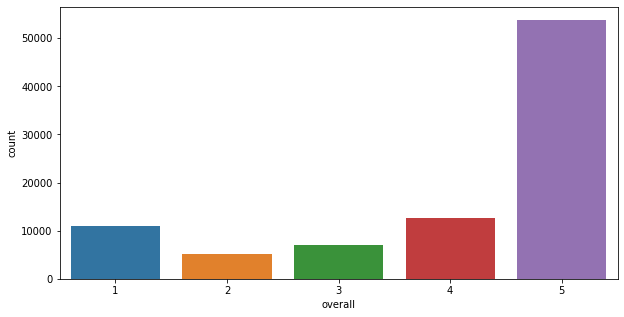

In [10]:
plt.figure(figsize=(10,5))
sns.countplot(x='overall',data=df_f)
plt.show()

説明変数として、`vote`(投票), `verified`(認証済み),`reviewTime`(レビューした時間),`reviewerID`(レビュワーID),`asin`(プロダクト ID), `reviewText`(レビューテキスト), `summary`(要約) 


In [11]:
x = df_f.loc[:,['vote', 'verified','reviewTime', 'reviewerID', 'asin', 'reviewText', 'summary']]
x.head()

,vote,verified,reviewTime,reviewerID,asin,reviewText,summary
0,9,False,"11 8, 2001",AH2IFH762VY5U,B00005N7P0,"for computer enthusiast, MaxPC is a welcome si...","AVID READER SINCE ""boot"" WAS THE NAME"
1,9,False,"10 31, 2001",AOSFI0JEYU4XM,B00005N7P0,Thank god this is not a Ziff Davis publication...,The straight scoop
2,14,False,"03 24, 2007",A3JPFWKS83R49V,B00005N7OJ,Antiques Magazine is a publication made for an...,"Antiques Magazine is Good, but not for Everyone"
3,13,False,"11 10, 2006",A19FKU6JZQ2ECJ,B00005N7OJ,This beautiful magazine is in itself a work of...,THE DISCERNING READER
4,NaN,True,"07 14, 2014",A25MDGOMZ2GALN,B00005N7P0,A great read every issue.,Five Stars


In [12]:
x.describe()

,vote,verified,reviewTime,reviewerID,asin,reviewText,summary
count,24103,89689,89689,89689,89689,89656,89670
unique,287,2,5804,72098,2428,79582,51160
top,2,True,"02 20, 2015",A3JPFWKS83R49V,B00005NIOH,Great magazine,Five Stars
freq,6318,58654,146,55,1718,233,14964


### 前処理

欠損値(`NaN`) の有無を調べる


In [13]:
y.isnull().sum()

overall    0
dtype: int64

In [14]:
x.isnull().sum()

vote          65586
verified          0
reviewTime        0
reviewerID        0
asin              0
reviewText       33
summary          19
dtype: int64

今回は、投票の欠損値を `0` で埋める。


In [16]:
x['vote'] = x['vote'].fillna(0)
x.head()

,vote,verified,reviewTime,reviewerID,asin,reviewText,summary
0,9,False,"11 8, 2001",AH2IFH762VY5U,B00005N7P0,"for computer enthusiast, MaxPC is a welcome si...","AVID READER SINCE ""boot"" WAS THE NAME"
1,9,False,"10 31, 2001",AOSFI0JEYU4XM,B00005N7P0,Thank god this is not a Ziff Davis publication...,The straight scoop
2,14,False,"03 24, 2007",A3JPFWKS83R49V,B00005N7OJ,Antiques Magazine is a publication made for an...,"Antiques Magazine is Good, but not for Everyone"
3,13,False,"11 10, 2006",A19FKU6JZQ2ECJ,B00005N7OJ,This beautiful magazine is in itself a work of...,THE DISCERNING READER
4,0,True,"07 14, 2014",A25MDGOMZ2GALN,B00005N7P0,A great read every issue.,Five Stars


In [17]:
df_f.reviewText.fillna("",inplace = True)

In [26]:
from wordcloud import WordCloud

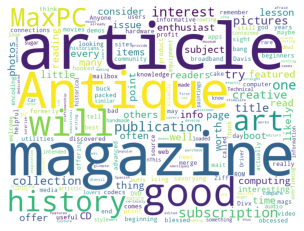

In [27]:
review_text = x['reviewText'].values 

wc = WordCloud(
    width=800, 
    height=600,
    background_color='white'
    )

review_wordcloud = wc.generate(str(review_text))

plt.imshow(review_wordcloud)
plt.axis("off")
plt.show()

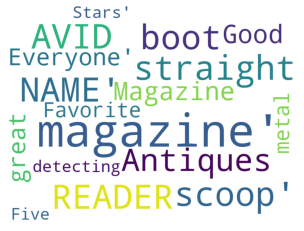

In [28]:
summary_text = x['summary'].values 

summary_wordcloud = wc.generate(str(summary_text))

plt.imshow(review_wordcloud)
plt.axis("off")
plt.show()